Goal: combine SNAP data, which is monthly trends over 100 years, and DayMet, which is daily data over recent history, to form a reasonable cycle of data following the SNAP trend but with reasonable daily cycles.

In [1]:
#%matplotlib

In [2]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
#import colors
import itertools

In [3]:
# short names for keys
k_T = 'air temperature [K]'
k_qSW = 'incoming shortwave radiation [W m^-2]'
k_qLW = 'incoming longwave radiation [W m^-2]'
k_Pr = 'precipitation rain [m s^-1]'
k_Ps = 'precipitation snow [m SWE s^-1]'
k_P = 'precipitation [m s^-1]'
k_RH = 'relative humidity [-]'
k_time = 'time [s]'
k_U = 'wind speed [m s^-1]'


In [4]:
def load_met(fname, adjust=-1,cycle=365):
    daymet = dict()
    with h5py.File(fname,'r') as _daymet:
        keys = _daymet.keys()
        assert(len(_daymet[k_time][:])%cycle == 0)
        daymet_nyears = int(len(_daymet[k_time][:]) / cycle)

        for k in keys:
            if k != k_time:
                daymet[k] = _daymet[k][:].reshape((daymet_nyears,cycle))
    try:
        daymet[k_P] = daymet[k_Pr] + daymet[k_Ps]
        if (adjust>1):
            daymet[k_P] = adjust*daymet[k_P]
    except KeyError:
        pass
    return daymet_nyears, daymet
  
def load_barrow_observed_met(fname, cycle=365):
    daymet = dict()
    with h5py.File(fname,'r') as _daymet:
        keys = _daymet.keys()
        end = 0
        if (len(_daymet[k_time][:])%cycle == 0):
            end = -1
        else:
            end = -(len(_daymet[k_time][:])%cycle)
        print (len(_daymet[k_time][:]),end)
        daymet_nyears = int(len(_daymet[k_time][:end]) / cycle)

        for k in keys:
            if k != k_time:
                daymet[k] = _daymet[k][:end].reshape((daymet_nyears,cycle))
    try:
        daymet[k_P] = daymet[k_Pr] + daymet[k_Ps]
    except KeyError:
        pass
    return daymet_nyears, daymet

In [7]:
#nyears, daymet = load_met('../Barrow_Alaska/barrow1985-2015-trend-smooth.h5',adjust=1.3)
nyears, daymet = load_met('../Barrow_Alaska/barrow1985-2015-detrend-smooth-30pc.h5',adjust=1)

year_dm = np.arange(1985, 1985+nyears)
normalization = dict()

nyears_bo, barrow_observed = load_barrow_observed_met('../Barrow_Alaska/Barrow-2010_2016-updated-smooth-30pc.h5')
year_bo = np.arange(2010, 2010+nyears_bo)

2513 -323


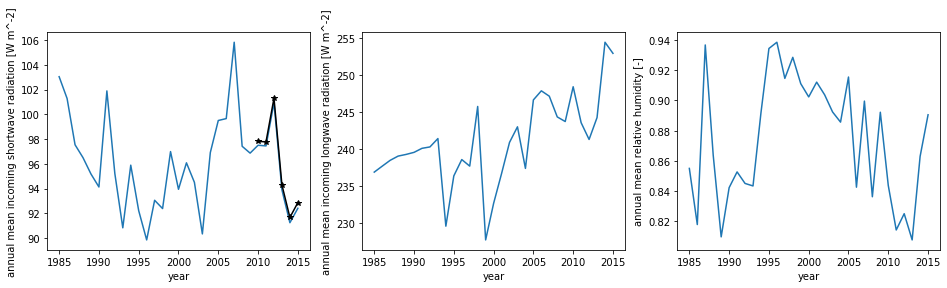

In [8]:
# check for trends in things we don't expect trends in
plt.figure(figsize=(16,4))

for i,k in enumerate([k_qSW, k_qLW, k_RH]):
    means = daymet[k].mean(1)
    plt.subplot(1,3,i+1)
    plt.plot(year_dm,means)
    plt.ylabel('annual mean %s'%k)
    plt.xlabel('year')
    if i == 0:
        means_bo = barrow_observed[k_qSW].mean(1)
        plt.plot(year_bo,means_bo, 'k-*', label='BO data annual mean')


plt.show()

# they look good now that wind speed has been detrended!  Look safe to use to me.
normalization[k_qSW] = daymet[k_qSW] / daymet[k_qSW].mean()
normalization[k_RH] = daymet[k_RH] - daymet[k_RH].mean()
normalization[k_qLW] = daymet[k_qLW] / daymet[k_qLW].mean()

[-1.98600480e-10 -1.93339384e-10 -1.88078289e-10 -1.82817193e-10
 -1.77556097e-10 -1.72295002e-10 -1.67033906e-10 -1.61772810e-10
 -1.56511714e-10 -1.51250619e-10 -1.45989523e-10 -1.40728427e-10
 -1.35467332e-10 -1.30206236e-10 -1.24945140e-10 -1.19684045e-10
  1.14422949e-10  5.10931521e-10  9.07440094e-10  1.30394867e-09
  1.70045724e-09  2.09696581e-09  2.49347438e-09  2.88998296e-09
  3.28649153e-09  3.68300010e-09  4.07950867e-09  4.47601724e-09
  4.87252582e-09  5.26903439e-09  5.66554296e-09]
[1.03475069 1.03386519 1.03079425 1.03914732 1.02201713 1.02971203
 1.05547297 1.03307308 1.02058584 1.02737261 1.04651186 1.03187515
 1.02492463 1.02426278 1.02697899 1.01638721 0.98361312 0.90353663
 0.88509726 0.82761383 0.75132086 0.69320363 0.50741379 0.65835134
 0.6489846  0.63308642 0.63481641 0.52320036 0.64301758 0.52192965
 0.39721922]
5.71500743925742e-09 5.9136079192826546e-09


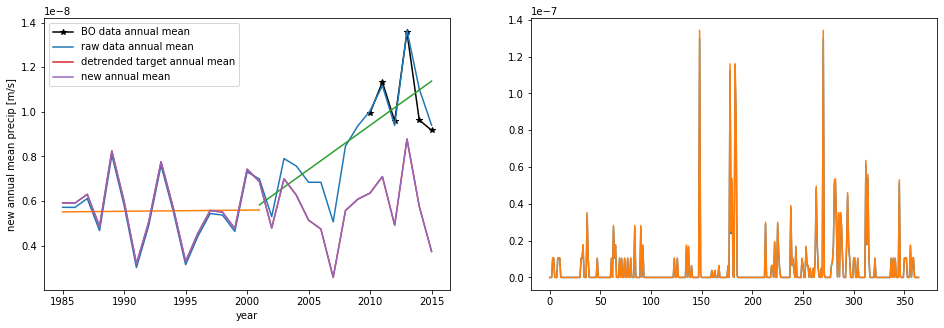

In [9]:
# do we need to detrend precip?

#Plot Observed Barrow Data 
means_bo = barrow_observed[k_P].mean(1)
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(year_bo,means_bo, 'k-*', label='BO data annual mean')
plt.ylabel('annual mean precip [m/s]')
plt.xlabel('year')


means = daymet[k_P].mean(1)
#plt.plot(daymet[k_P][10])#, label='RRraw data annual mean')

plt.plot(year_dm,means, label='raw data annual mean')
plt.ylabel('annual mean precip [m/s]')
plt.xlabel('year')

# detrend the first 17 years?
polyfit = np.poly1d(np.polyfit(np.arange(0,17), means[0:17], deg=1))
plt.plot(year_dm[:17], polyfit(np.arange(0,17)))

# detrend the last 15 years?
polyfit2 = np.poly1d(np.polyfit(np.arange(nyears-15, nyears), means[-15:], deg=1))
plt.plot(year_dm[16:], polyfit2(np.arange(nyears-15,nyears)))

# shift the means
center = (polyfit(16) + polyfit2(nyears-15))/2.
mean_shift = np.zeros((nyears,),'d')
mean_shift[0:17] = polyfit(np.arange(0,17)) - center
mean_shift[-15:] = polyfit2(np.arange(nyears-15,nyears)) - center
print(mean_shift)
plt.plot(year_dm, means - mean_shift, label='detrended target annual mean')

# transform precip by scaling -- this is necessary to keep positive
# effectively this means that all changes in precip will be changes in precip intensity.  
# This is equivalent to duration over a day, i.e. we see no difference between raining
# twice as hard and raining twice as long over a given day.  But it doesn't introduce 
# more events or make it rain on days it doesn't currently rain on.
transform = (means - mean_shift) / means
print(transform)
precip = np.array([daymet[k_P][i,:]*(means[i] - mean_shift[i])/means[i] for i in range(nyears)])
new_means = precip.mean(1)

plt.plot(year_dm,new_means, label='new annual mean')
plt.ylabel('new annual mean precip [m/s]')
plt.xlabel('year')
plt.legend()

plt.subplot(122)
plt.plot(daymet[k_P][0,:])
plt.plot(precip[0])
print(daymet[k_P][0,:].mean(), precip[0].mean())

plt.show()

# normalize to 1, then save
normalization[k_P] = precip / precip.mean()

[ 0.1055266   0.09336708  0.08120757  0.06904806  0.05688855  0.04472904
  0.03256952  0.02041001  0.0082505  -0.00390901 -0.01606852 -0.02822804
 -0.04038755 -0.05254706 -0.06470657 -0.07686608  0.0890256   0.08428572
  0.07954584  0.07480596  0.07006609  0.06532621  0.06058633  0.05584645
  0.05110658  0.0463667   0.04162682  0.03688694  0.03214707  0.02740719
  0.02266731]
262.897994167288 262.93407239150565


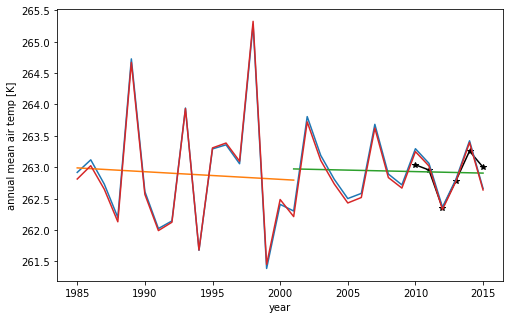

In [10]:
# do we need to detrend air temp?
#Plot Observed Barrow Data 
means_bo = barrow_observed[k_T].mean(1)
plt.figure(figsize=(8,5))
plt.plot(year_bo,means_bo, 'k-*', label='BO data annual mean')
plt.ylabel('annual mean air temp [K]')
plt.xlabel('year')

means = daymet[k_T].mean(1)
#plt.figure()
plt.plot(year_dm,means, label='raw data annual mean')
plt.ylabel('annual mean air temp [K]')
plt.xlabel('year')

# again, do with a split at the 17th year...
# detrend the first 17 years?
polyfit = np.poly1d(np.polyfit(np.arange(0,17), means[0:17], deg=1))
plt.plot(year_dm[:17], polyfit(np.arange(0,17)))

# detrend the last 15 years?
polyfit2 = np.poly1d(np.polyfit(np.arange(nyears-15, nyears), means[-15:], deg=1))
plt.plot(year_dm[16:], polyfit2(np.arange(nyears-15,nyears)))

# shift the means
center = (polyfit(16) + polyfit2(nyears-15))/2.
mean_shift = np.zeros((nyears,),'d')
mean_shift[0:17] = polyfit(np.arange(0,17)) - center
mean_shift[-15:] = polyfit2(np.arange(nyears-15,nyears)) - center
print(mean_shift)
plt.plot(year_dm,means - mean_shift, label='detrended target annual mean')

print (np.mean(means_bo),np.mean(means) )
plt.show()

[-7.51058348e-05 -7.00987791e-05 -6.50917235e-05 -6.00846678e-05
 -5.50776122e-05 -5.00705565e-05 -4.50635009e-05 -4.00564452e-05
 -3.50493896e-05 -3.00423339e-05 -2.50352783e-05 -2.00282227e-05
 -1.50211670e-05 -1.00141114e-05 -5.00705573e-06 -5.68434189e-14
  5.00705556e-06  1.00141112e-05  1.50211669e-05  2.00282225e-05
  2.50352782e-05  3.00423338e-05  3.50493895e-05  4.00564451e-05
  4.50635007e-05  5.00705564e-05  5.50776120e-05  6.00846677e-05
  6.50917233e-05  7.00987790e-05  7.51058346e-05]


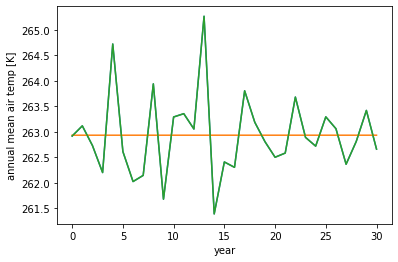

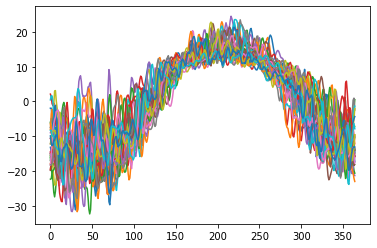

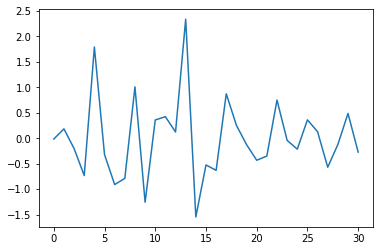

In [11]:
# actually that's just a flat line...
plt.figure()
plt.plot(means, label='raw data annual mean')
plt.ylabel('annual mean air temp [K]')
plt.xlabel('year')

polyfit = np.poly1d(np.polyfit(np.arange(0,nyears), means, deg=1))
plt.plot(np.arange(0,nyears), polyfit(np.arange(0,nyears)))

# shift the means
mean_shift = polyfit(np.arange(0,nyears)) - means.mean()
print(mean_shift)
plt.plot(means - mean_shift, label='detrended target annual mean')

# shift the data
air_temp = np.array([daymet[k_T][i,:] - mean_shift[i] for i in range(nyears)])

# save normalization as zero-mean
normalization[k_T] = air_temp - air_temp.mean()

plt.figure()
for ta in normalization[k_T]:
    plt.plot(ta)

plt.figure()
plt.plot(normalization[k_T].mean(1))

plt.show()

In [ ]:
# load the SNAP data
nyears_s, snap = load_met("snap-2006-2100-monthly.h5", cycle=12)
year_s = np.arange(2006, 2006+nyears_s)


In [12]:
# also load CESM RCP4.5 just for comparison sake
nyears_c, cesm45 = load_met("../CESM/CESM_4_5.h5", cycle=365)
year_c = np.arange(2006, 2006+nyears_c)

nyears_c85, cesm85 = load_met("../CESM/CESM_8_5.h5", cycle=365)


In [13]:
#cm = colors.cm_mapper(0,3)
cm = ['b','k','r','g','c','p']
def plot(yr, ds, k, label, i):
    plt.plot(yr, ds[k].mean(1), label=label, color=cm[i])
    poly = np.poly1d(np.polyfit(yr, ds[k].mean(1), deg=1))
    plt.plot(yr, poly(yr), color=cm[i])
    return poly

poly_trends = dict()
for dset in ['DayMet', 'SNAP', 'CESM RCP4.5', 'CESM RCP8.5']:
    poly_trends[dset] = dict()
    
def plot_all(k):
    poly_trends['DayMet'][k] = plot(year_dm, daymet, k, 'DayMet', 0)
    #poly_trends['SNAP'][k] = plot(year_s, snap, k, 'SNAP', 1)
    #poly_trends['CESM RCP4.5'][k] = plot(year_c, cesm45, k, 'CESM RCP4.5', 2)
    poly_trends['CESM RCP8.5'][k] = plot(year_c, cesm85, k, 'CESM RCP8.5', 3)
    #plt.plot(year_bo,means_bo, 'r-*', label='BO data annual mean')
    plt.xlabel('year')
    plt.ylabel("annual mean %s"%k)
    plt.legend()



/Users/ajc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


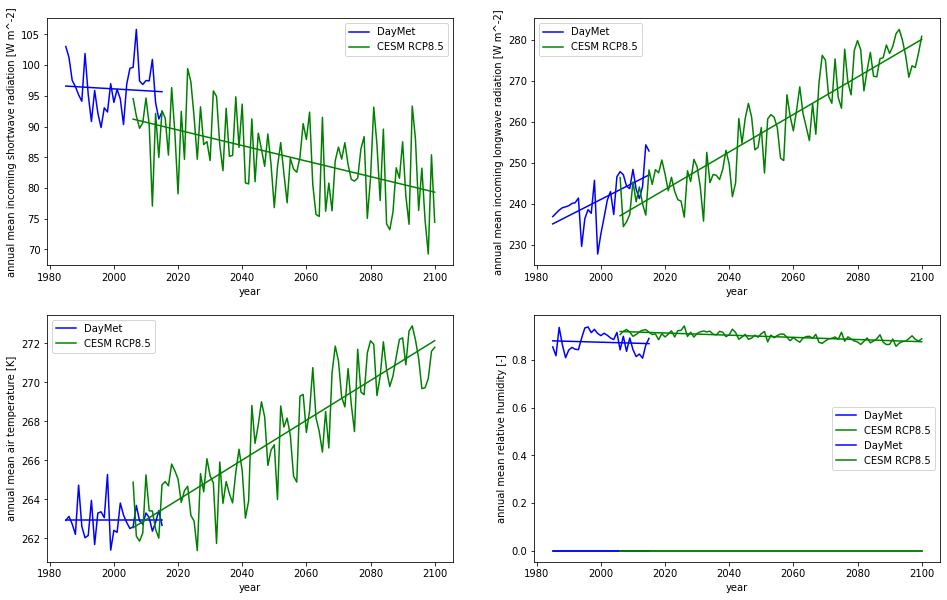

In [14]:
# check for trends
plt.figure(figsize=(16,10))
plt.subplot(221)
plot_all(k_qSW)
plt.subplot(222)
plot_all(k_qLW)
plt.subplot(223)
plot_all(k_T)
plt.subplot(224)
plot_all(k_P)
plt.subplot(224)
plot_all(k_RH)
plt.show()

In [15]:
# utilities
def year_generator(dat):
    print ('Shape: ',dat.shape[0])
    for i in itertools.cycle(range(dat.shape[0])):
        #print (i,len(dat[i,:]))
        yield dat[i,:]
       
    
def plot(years, precip_proj, trend_poly, k):
    plt.figure(figsize=(16,7))
    plt.plot(np.arange(years[0], years[-1]+1, 1.0/365), precip_proj.ravel())
    plt.plot(np.arange(year_dm[0], year_dm[-1]+1, 1.0/365), daymet[k].ravel())

    plt.plot(year_dm, poly_trends['DayMet'][k](year_dm))
    plt.plot(year_dm, daymet[k].mean(1))
    plt.plot(years, trend_poly(years))
    plt.plot(years, precip_proj.mean(1))
    plt.xlabel('year')
    plt.ylabel(k)
    plt.show()   
    
def project_and_plot(years, trend_poly, normalized, k, operator='additive'):
    print("Projecting: %s"%k)
    if operator == 'additive':
        
        for yr, pr in zip(years, [0,1,2]):#year_generator(normalized)):
            print (yr)
        precip_proj = np.array([pr + trend_poly(yr) for yr, pr in zip(years, year_generator(normalized))])
    elif operator == 'multiplicative':
        precip_proj = np.array([pr*trend_poly(yr) for yr, pr in zip(years, year_generator(normalized))])
    else:
        raise RuntimeError('invalid operator, must be "additive" or "multiplicative"')
    print(precip_proj.shape)
    plot(years, precip_proj, trend_poly, k)
    
    # check min/max are reasonable
    print(precip_proj.min(), precip_proj.max())
    return precip_proj  


In [16]:
# projected dataset
proj = dict()


In [ ]:
# use snap precip
#proj[k_P] = project_and_plot(year_s, poly_trends['SNAP'][k_P], normalization[k_P], k_P, operator="multiplicative")

Projecting: air temperature [K]
2006
2007
2008
Shape:  31
(95, 365)


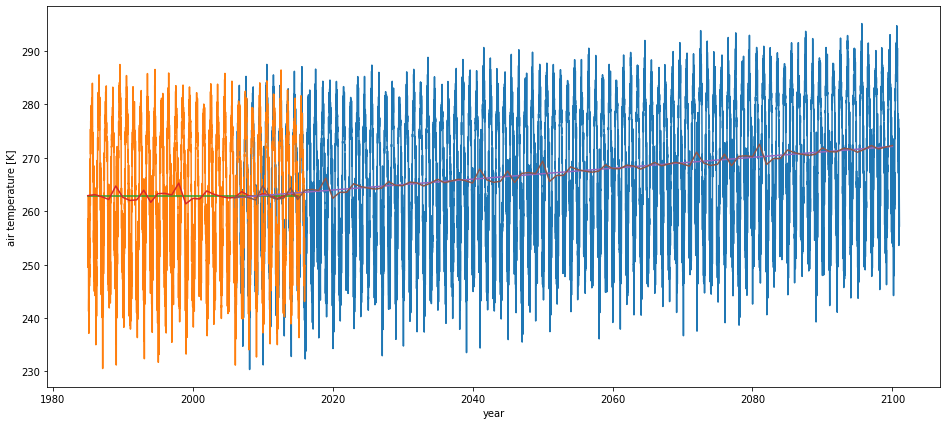

230.37178114214748 295.1398392244379
Projecting: relative humidity [-]
2006
2007
2008
Shape:  31
(95, 365)


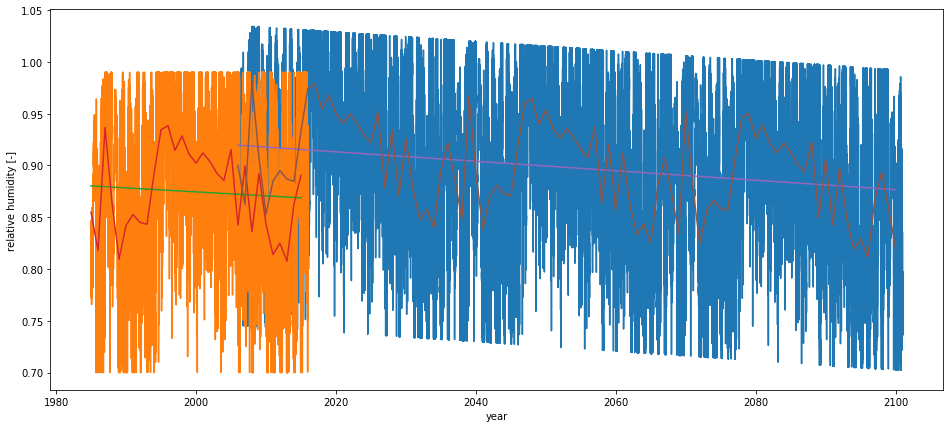

0.702120383617496 1.0342111533794212
Projecting: incoming shortwave radiation [W m^-2]
Shape:  31
(95, 365)


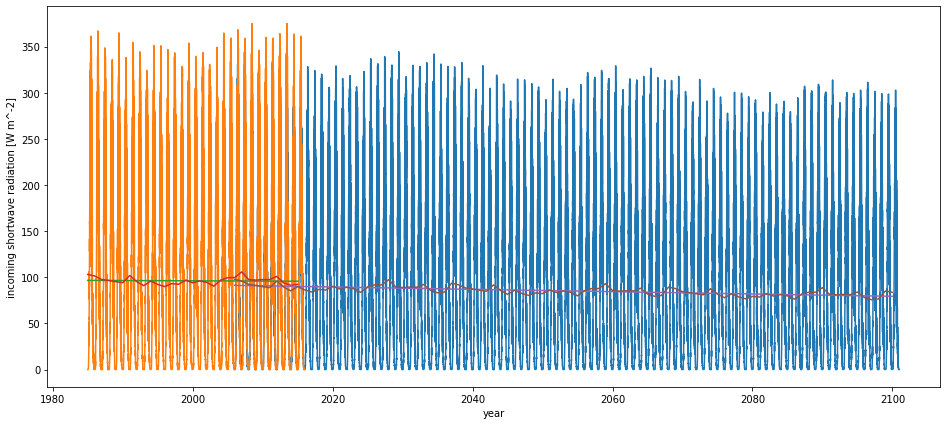

0.0 347.6587892859232
Projecting: incoming longwave radiation [W m^-2]
Shape:  31
(95, 365)


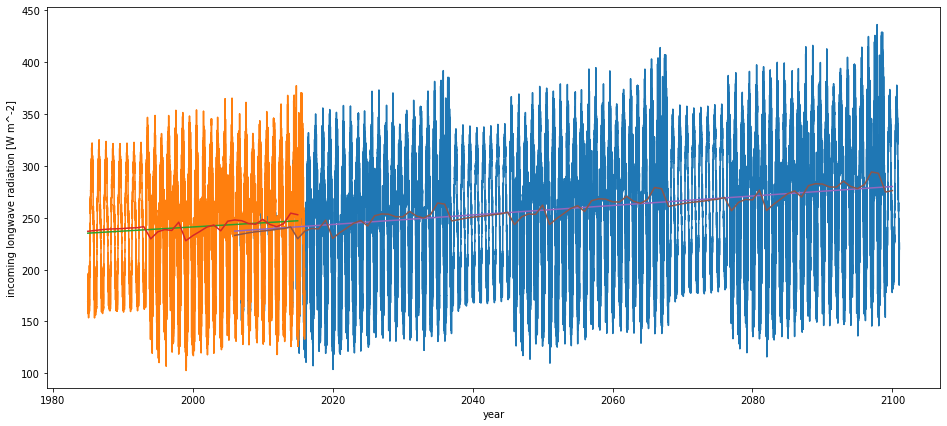

103.77990571800422 436.1519885874104
Projecting: precipitation [m s^-1]
Shape:  31
(95, 365)


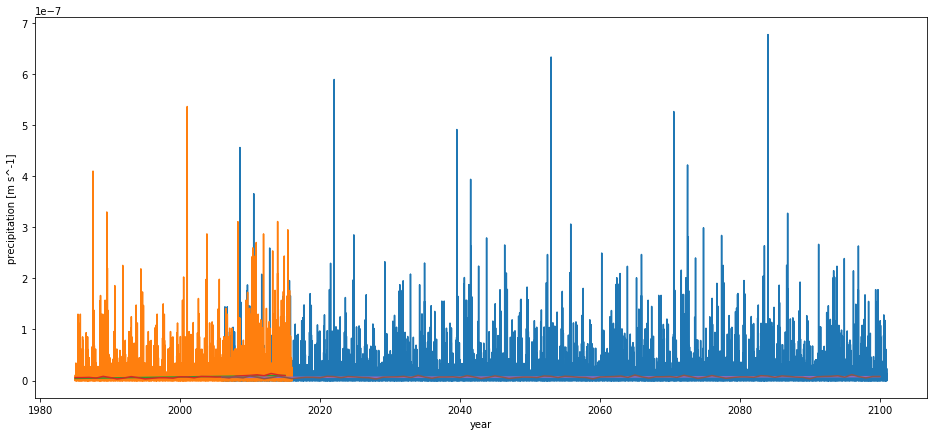

0.0 6.766189288817098e-07


In [17]:
# use CESM RCP8.5 air temperatures, RH, and incoming SW
proj[k_T] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_T], normalization[k_T], k_T, operator='additive')
proj[k_RH] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_RH], normalization[k_RH], k_RH, operator='additive')
proj[k_qSW] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_qSW], normalization[k_qSW], k_qSW, operator='multiplicative')
proj[k_qLW] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_qLW], normalization[k_qLW], k_qLW, operator='multiplicative')

proj[k_P] = project_and_plot(year_c, poly_trends['CESM RCP8.5'][k_P], normalization[k_P], k_P, operator='multiplicative')


# uh oh, need to filter RH

In [18]:
def filter(dat, min_val, max_val, policy='avg'):
    if policy == 'clip':
        dat = np.where(dat > max_val, max_val, dat)
        dat = np.where(dat < min_val, min_val, dat)
        return dat
    elif policy == 'avg':
        bad_high = np.where(dat > max_val)[0]
        for bh in bad_high:
            bh_l = bh - 1
            while bh_l in bad_high:
                bh_l -= 1
                
            bh_u = bh + 1
            while bh_u in bad_high:
                bh_u += 1
            
            if bh_l < 0:
                dat[bh] = dat[bh_u]
            elif bh_u >= len(dat):
                dat[bh] = dat[bh_l]
            else:
                dat[bh] = (dat[bh_u] + dat[bh_l]) / 2.

        bad_low = np.where(dat < min_val)[0]
        for bh in bad_low:
            bh_l = bh - 1
            while bh_l in bad_low:
                bh_l -= 1
                
            bh_u = bh + 1
            while bh_u in bad_low:
                bh_u += 1
            
            if bh_l < 0:
                dat[bh] = dat[bh_u]
            elif bh_u >= len(dat):
                dat[bh] = dat[bh_l]
            else:
                dat[bh] = (dat[bh_u] + dat[bh_l]) / 2. 
        return dat
    else:
        raise RuntimeError('Policy must be "avg" or "clip"')



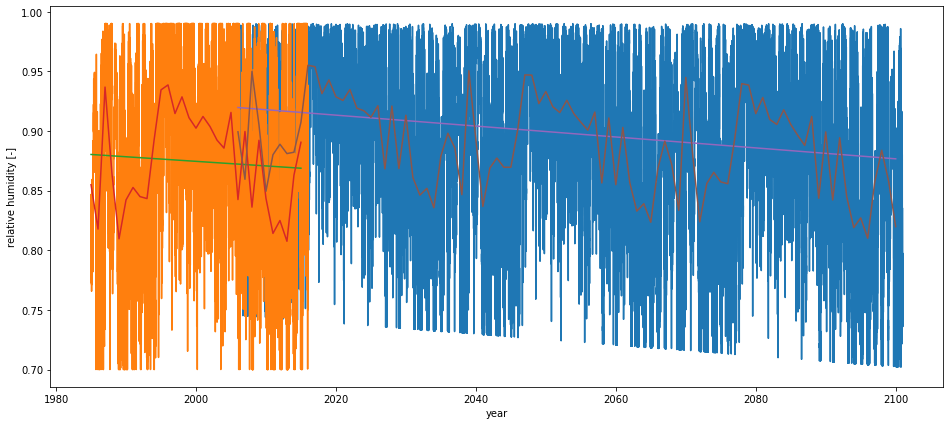

In [19]:
# filter RH
shp = proj[k_RH].shape
proj[k_RH] = filter(proj[k_RH].ravel(), 0.5, 0.99, 'avg').reshape(shp)

plot(year_c, proj[k_RH], poly_trends['CESM RCP8.5'][k_RH], k_RH)


Shape:  31
0.001 20.0
0.001 20.0


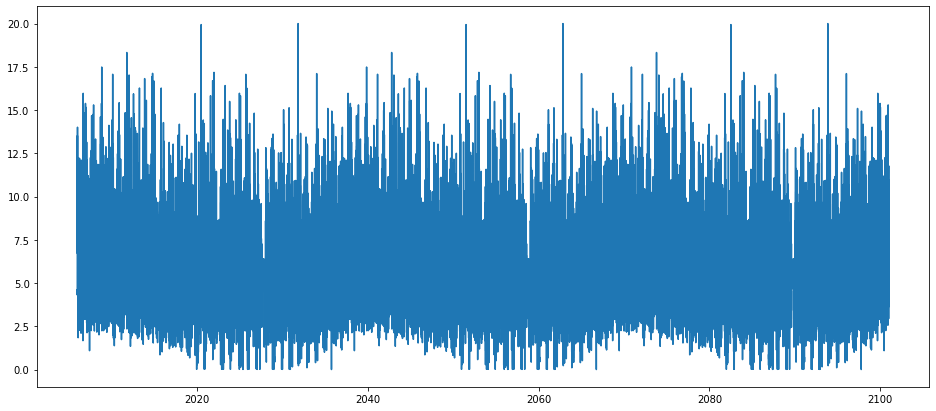

In [20]:
# just cycle wind speed
proj[k_U] = np.array([d for i,d in zip(range(len(year_c)), year_generator(daymet[k_U]))])
plt.figure(figsize=(16,7))
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_U].ravel())

print(daymet[k_U].min(), daymet[k_U].max())
print(proj[k_U].min(), proj[k_U].max())

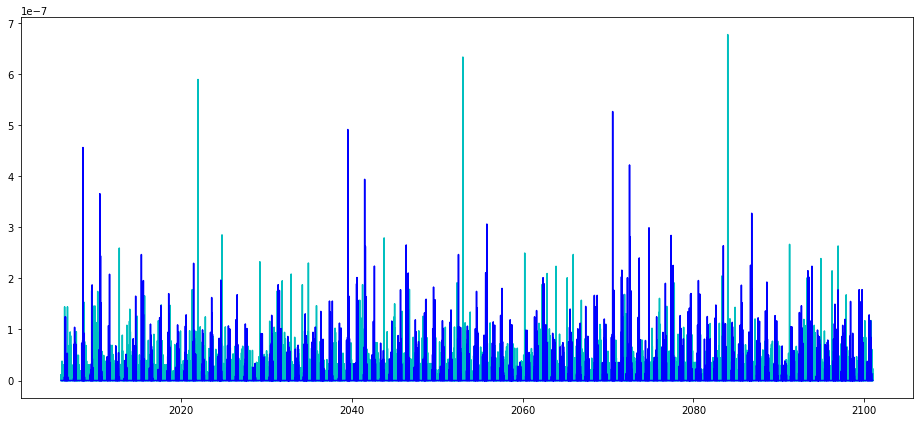

In [21]:
# partition rain
#precip = proj.pop(k_P)

#proj[k_Ps] = np.where(proj[k_T] > 273.15, 0., precip)
#proj[k_Pr] = np.where(proj[k_T] > 273.15, precip, 0)

proj[k_Ps] = np.where(proj[k_T] >= 273.15, 0., proj[k_P])
proj[k_Pr] = np.where(proj[k_T] > 273.15, proj[k_P], 0)

plt.figure(figsize=(16,7))
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_Ps].ravel(), 'c')
plt.plot(np.arange(year_c[0], year_c[-1]+1, 1.0/365), proj[k_Pr].ravel(), 'b')
plt.show()



In [23]:
# save to file
times = np.arange(86400./2, len(year_c) * 365 * 86400 +1, 86400)
assert(len(times) == 365*95)

with h5py.File("CESM-RCP8.5-2006-2100_snowadjusted.h5",'w') as fout:
    fout.create_dataset(k_time, data=times)
    for k in proj.keys():
        fout.create_dataset(k, data=proj[k].ravel())

    